# Dependencies installation
we'll first try to fetch a pre-installed dependencies from google-drive, if it doesn't exist, we'll install it there for faster loading next *time*

In [83]:
import numpy as np
from tqdm.notebook import tqdm

from src.channel_simulation import *
from src.output import Outputs
from src.params import Params

# Deep Learning research

## BER vs normalization factor

In [84]:
def iterate_through_channel(par):
    o2 = Outputs()
    o2.x[0] = Step0.generate_message(par)
    o2.x[1], o2.modem = Step1.modulate(o2.x[0], par)
    o2.x[2] = Step2.over_sample(o2.x[1], par)
    o2.x[3], o2.h_rrc, o2.L_rrc = Step3.pulse_shape(o2.x[2], par)
    o2.x[4] = Step4.pre_equalize(o2.x[3], par)
    Step5.add_nft_params(o2.x[4], par, o2)
    o2.x[5] = Step5.inft(o2.x[4], par, o2)
    o2.x[6] = Step6.channel(o2.x[5], par)
    o2.x[7] = Step7.nft(o2.x[6], par, o2)
    o2.x[8] = Step8.equalizer(o2.x[7], par)
    o2.x[9] = Step9.match_filter(o2.x[8], par, o2)
    o2.x[10], ber, num_errors = Step10.demodulate(o2.x[9], par, o2, o2.x[0], o2.modem)
    return ber, num_errors

In [85]:
def run_n_times(par, n=10, pbar=None) -> float:
    # outputs BER from N realisations
    num_errors = 0
    for r in range(n):
        num_errors += iterate_through_channel(par)[1]
        if pbar: pbar.update(1)
    ber = num_errors / (n * par.length_of_msg)
    return ber, num_errors

In [86]:
def create_us_vec(n_steps=10, min_u=-2.5, max_u=-1):
    normalizing_factors = 10 ** np.linspace(min_u, max_u, n_steps)
    return normalizing_factors

In [93]:
def ber_vs_us(par, normalizing_factors, n_realisations=10,
              pbar_title=None):
    bers = []
    num_errors_vec = []
    pbar = tqdm(total=n_realisations*len(normalizing_factors), leave=True, position=0)
    if pbar_title: pbar.set_description_str(pbar_title)
    for i, u in enumerate(normalizing_factors):
        par.normalization_factor = u
        ber_i, num_errors_i = run_n_times(par, n_realisations, pbar)
        bers.append(ber_i)
        num_errors_vec.append(num_errors_i)
    errs = np.array(num_errors_vec)
    return np.array(bers), errs

In [101]:
def plot_bers(us, bers_vecs, legends=None):
    plt.figure(figsize=[10, 5])
    for bers in bers_vecs:
        mean = bers.mean(axis=-1)
        std = bers.std(axis=-1)
        plt.semilogx(us, bers)
        # plt.fill_between(us,mean-std,mean+std,alpha=0.4)

    plt.xlabel('normalizing factor'), plt.ylabel('BER')
    plt.title('BER vs normalizing factor')
    plt.grid(which='both', axis='y')
    plt.grid(which='major', axis='x')
    # plt.ylim(top=1,bottom=3e-4)
    if legends: plt.legend(legends)
    plt.show()


In [89]:
np.set_printoptions(
    edgeitems=3,
    threshold=1000,
    floatmode='maxprec',
    precision=4,  #8,
    suppress=True,  # False,
    linewidth=75,
    nanstr='nan',
    infstr='inf',
    sign='-',
    formatter=None,
    legacy=False
)
np.get_printoptions()

{'edgeitems': 3,
 'threshold': 1000,
 'floatmode': 'maxprec',
 'precision': 4,
 'suppress': True,
 'linewidth': 75,
 'nanstr': 'nan',
 'infstr': 'inf',
 'sign': '-',
 'formatter': None,
 'legacy': False}

normalizing factors are: [0.0032 0.0046 0.0068 0.01   0.0147 0.0215 0.0316 0.0464 0.0681 0.1   ]


  0%|          | 0/100 [00:00<?, ?it/s]

64 symbols: errors found = [0 0 0 0 0 0 0 0 0 0] / [2560 = 256 bits * 10 realisations]


  0%|          | 0/100 [00:00<?, ?it/s]

128 symbols: errors found = [0 0 0 0 0 0 1 0 0 0] / [5120 = 512 bits * 10 realisations]


  0%|          | 0/100 [00:00<?, ?it/s]

256 symbols: errors found = [1 0 0 0 0 0 0 0 0 0] / [10240 = 1024 bits * 10 realisations]


  0%|          | 0/100 [00:00<?, ?it/s]

512 symbols: errors found = [0 0 1 0 1 0 0 0 0 1] / [20480 = 2048 bits * 10 realisations]


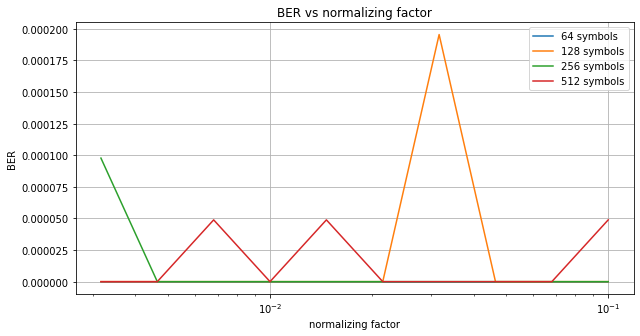

In [118]:
# test the impact of ber vs normalization factor for multiple n_symbols
p2 = Params(m_qam=16,
            plot_vec_after_creation=False)
o2 = Outputs()

num_realisations = 10
us_vec = create_us_vec(n_steps=10, min_u=-2.5, max_u=-1)
N_symbols_vec = np.array([64, 128, 256, 512])

print(f'normalizing factors are: {us_vec}')

bers_vec, legends = [], []
for n_sym in N_symbols_vec:
    p2.num_symbols = n_sym
    bers, errs = ber_vs_us(p2, us_vec, n_realisations=num_realisations)
    print(f'{n_sym} symbols: errors found = {errs} / [{p2.length_of_msg*num_realisations} = {p2.length_of_msg} bits * {num_realisations} realisations]')
    bers_vec.append(bers)
    legends.append(f'{n_sym} symbols')

plot_bers(us_vec, bers_vec, legends)

# TODOs:


* add channel - *split step fourier algorithm*
(algorithm is at agrawal 2.4.1 [2.3.46 equation without alpha] paper)
  it includes the noise (at first we can neglect it)
  * with channel the results should be similiar if


Done:
* add BER at the end
* perhaps loop the BW thing further up with BER as result function
* make a graph of BER as function of normalizing factor
* make the number of symbols: 500 - 1000 check that the ber improves (power of two)
* check on symbols: [64 :power of 2 :512]
